In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_30 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-20 09:40:36.942436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=525,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30_large_som"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(26,26), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[Epoch 50] KL weight: 0.0020, KL: 1.3396
[VAE Pretrain] Epoch 50/300 Avg ELBO: -383.1487 (Recon: -384.4883, KLw: 1.3396)
[Epoch 100] KL weight: 0.0041, KL: 2.9437
[VAE Pretrain] Epoch 100/300 Avg ELBO: -441.1123 (Recon: -444.0560, KLw: 2.9437)
[Epoch 150] KL weight: 0.0062, KL: 4.4868
[VAE Pretrain] Epoch 150/300 Avg ELBO: -463.0775 (Recon: -467.5643, KLw: 4.4868)
[Epoch 200] KL weight: 0.0083, KL: 5.9874
[VAE Pretrain] Epoch 200/300 Avg ELBO: -476.9693 (Recon: -482.9566, KLw: 5.9874)
[Epoch 250] KL weight: 0.0100, KL: 7.4142
[VAE Pretrain] Epoch 250/300 Avg ELBO: -516.8764 (Recon: -524.2906, KLw: 7.4142)
[Epoch 300] KL weight: 0.0100, KL: 6.4297
[VAE Pretrain] Epoch 300/300 Avg ELBO: -260.2902 (Recon: -266.7199, KLw: 6.4297)


In [8]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage1/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [ ]:
init_loader = DataLoader( dataset_train,batch_size=676,sampler=train_sampler,collate_fn=vital_pre_train )

In [13]:
initialize_som_from_data(model1, init_loader, device, som_dim=(26, 26), num_classes=4, samples_per_class=169)

[SOM Init] initialize SOM embeddings：676 vectors, each class has 169。


In [14]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0115
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0114
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0113
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0090
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0090
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0089
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0088
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0087
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0088


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage2/best_som.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>

In [16]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100,kappa= 150, beta= 200, 
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 676])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 676])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


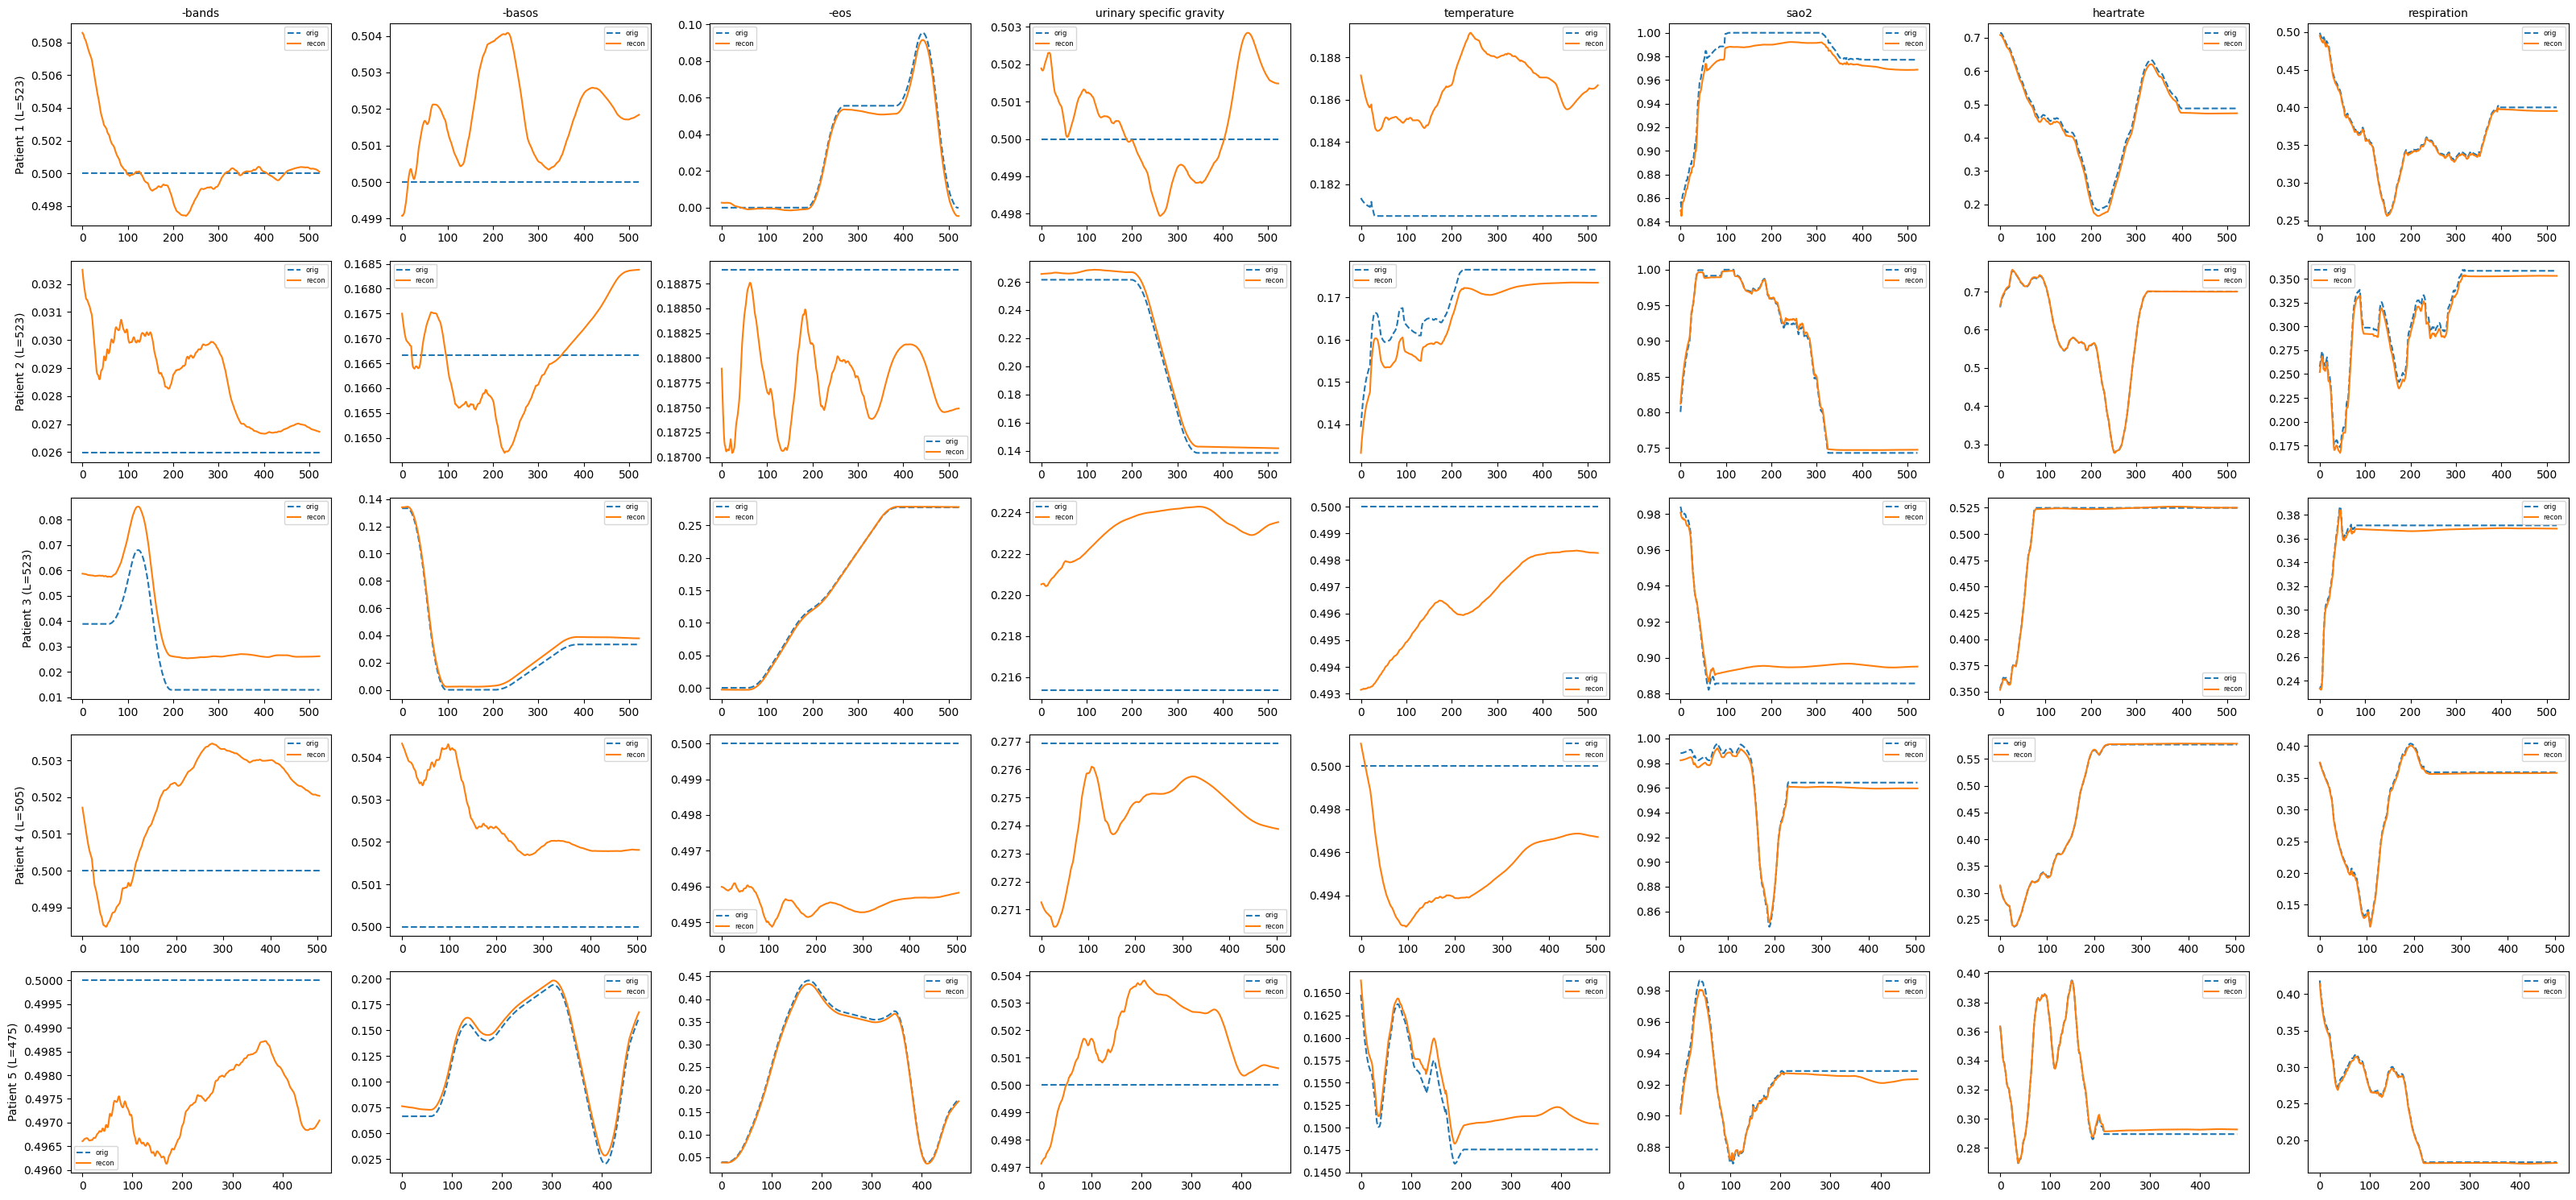

In [17]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 161863 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0008
  Std (overall): 0.2173
  Per-dim mean:
tensor([ 2.1186e-02, -1.5798e-02, -2.6411e-03,  8.0928e-03, -5.4763e-03,
        -2.4096e-02,  4.2342e-03, -1.3689e-03,  2.7425e-03,  3.7723e-03,
        -1.7304e-02, -2.7518e-03, -1.2448e-02,  1.7234e-02, -2.6120e-02,
        -4.1959e-03, -3.9901e-03, -1.4698e-02,  4.5544e-03, -1.7242e-03,
        -1.3797e-02,  2.2458e-03,  1.4378e-02, -1.3203e+00, -5.5812e-03,
        -2.3029e-02, -5.0015e-03,  5.7707e-03,  1.3301e-02,  1.0412e-02,
         1.4826e-02,  2.3849e-02,  2.5214e-02,  1.1291e-02,  2.1630e-02,
         1.0316e-02,  1.7774e-02,  7.1206e-03,  9.0546e-03,  1.1540e-02,
        -6.6542e-03,  7.8440e-01, -8.9440e-03, -9.1135e-03,  5.2175e-03,
        -8.7137e-01, -4.4337e-03, -6.5814e-04, -4.8380e-03,  6.8741e-03,
         1.1082e-02,  2.4997e-02, -1.8170e-02,  1.6205e-02,  4.9825e-01,
        -5.8410e-03,  1.0019e-02,  1

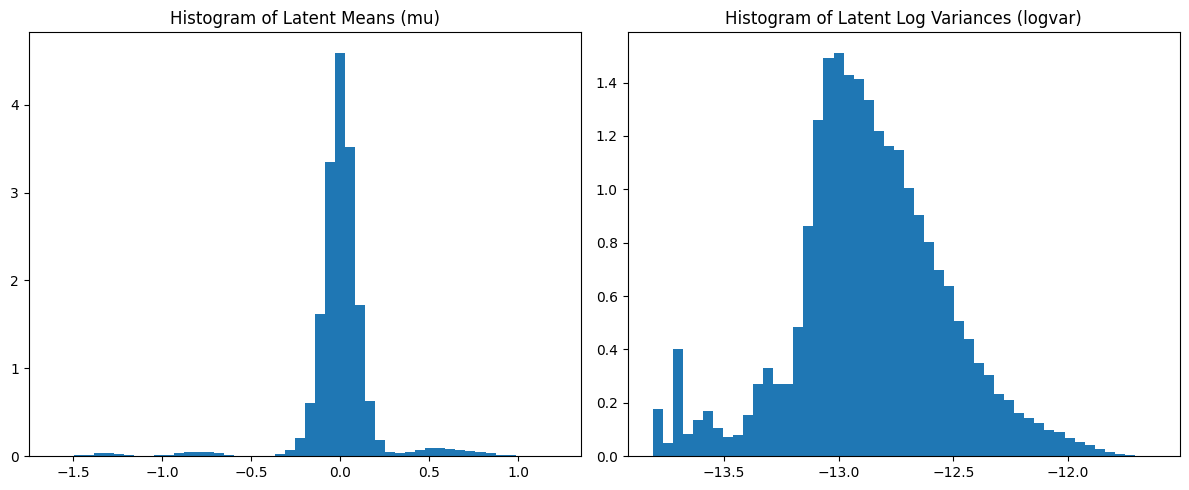

In [18]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

In [10]:
stage3 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage3/best_joint.pth'
model3 =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model3.load_state_dict(torch.load(stage3, map_location=device,weights_only=True))

<All keys matched successfully>

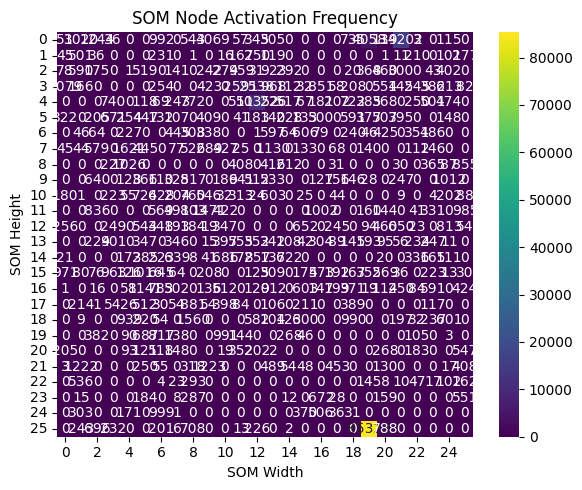

In [19]:
activation_map = compute_som_activation_heatmap(model3,test_loader, device)
plot_som_activation_heatmap(activation_map)

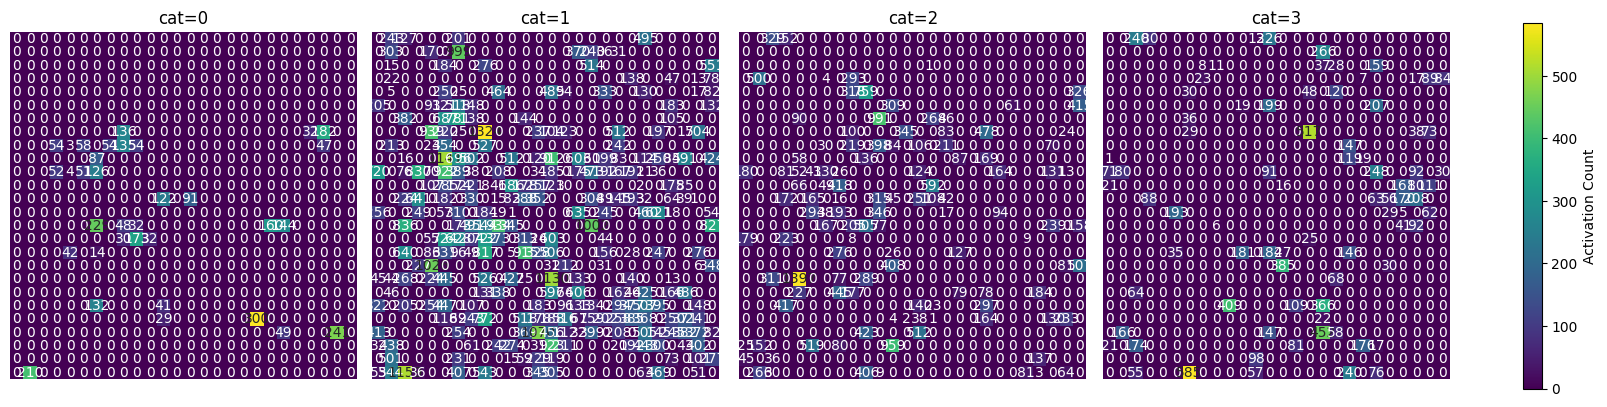

In [20]:

som_dim = (26,26)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

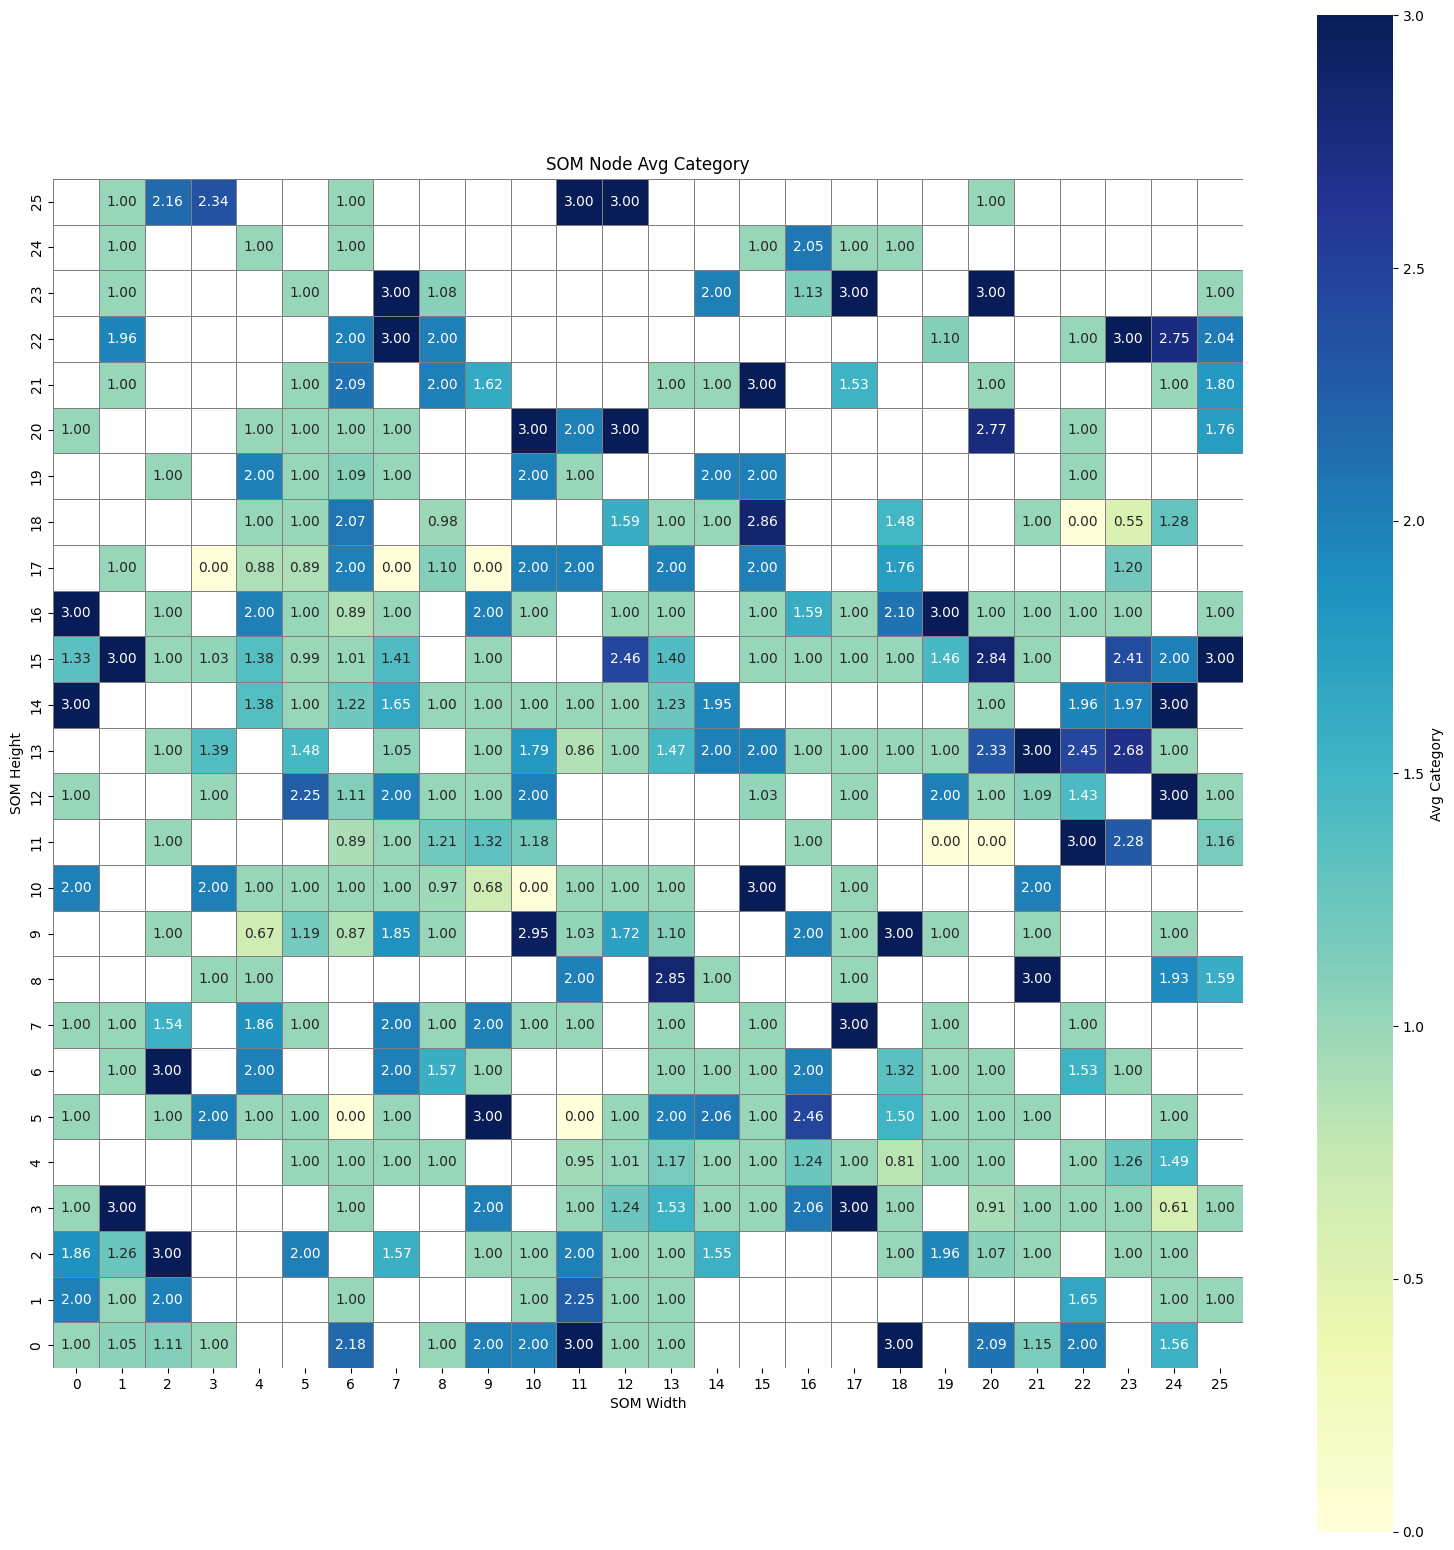

In [21]:

som_dim = (26,26)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)